In [2]:
%matplotlib inline
## imports

# site
from matplotlib import pyplot as plt
import numpy as np
import rasterio
import flopy

# std
from pathlib import Path
import yaml

In [25]:
def read_array(rasterfile, masked=True,  band=1):
    with rasterio.open(rasterfile) as src:
        return src.read(band, masked=masked)

In [26]:
def read_3d_array(rasterfiles, stack_axis=0, masked=True):
    arrays = []
    for rasterfile in rasterfiles:
        arrays.append(read_array(rasterfile, masked=masked))
    return np.ma.stack(arrays, axis=stack_axis)

In [4]:
data_dir = Path('../../mf6/data')

In [37]:
## input

# name
name = 'test_npf_brabant'

# workspace
workspace = Path(r'../output/npf')

# grid dimensions
nlay = 19
nrow = 450
ncol = 601
delr = 250.
delc = 250.

# data files
idomainfile = data_dir / 'boundary/IBOUND.tif'
topfile = str(data_dir / 'topbot/RL{ilay:}.tif')
botfile = str(data_dir / 'topbot/TH{ilay:}.tif')

In [27]:
# read idomain
idomain = read_array(idomainfile).filled(0.)
print(idomain.shape)

(450, 601)


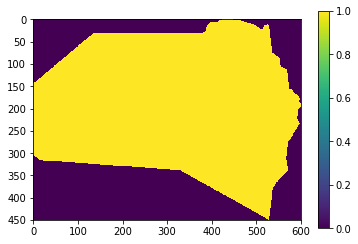

In [28]:
# show idomain
plt.imshow(idomain)
plt.colorbar()

In [39]:
# read tops
topfiles = (Path(topfile.format(ilay=i + 1)) for i in range(nlay))

tops = read_3d_array(topfiles)

# mask bad nodata values
tops = np.ma.masked_where(tops.mask | (tops < -9990.), tops)

# fill masked with zeros
tops = tops.filled(0.)

print(tops.shape)

(19, 450, 601)


In [40]:
# read bots
botfiles = (Path(botfile.format(ilay=i + 1)) for i in range(nlay))

bots = read_3d_array(botfiles)

# mask bad nodata values
bots = np.ma.masked_where(bots.mask | (bots < -9990.), bots)

# fill masked with zeros
bots = bots.filled(0.)

print(bots.shape)

(19, 450, 601)


In [41]:
# convert to top, botm
top = tops[0, :, :]
botm = []
for ilay in range(nlay):
    botm.append(bots[ilay, :, :])
    if (ilay + 1) < nlay:
        botm.append(tops[ilay + 1, :, :])
botm = np.ma.stack(botm)
print(botm.shape)

(37, 450, 601)


In [42]:
# idomain
idomain = np.broadcast_to(idomain, botm.shape)
print(idomain.shape)

(37, 450, 601)


In [44]:
k11 = np.zeros(idomain.shape, dtype=np.float)
k33 = np.zeros(idomain.shape, dtype=np.float)
for idx in range(botm.shape[0]):
    print(idx)
    if idx % 2 == 0:
        layer_trans_file = data_dir / f'kdc/TX{layer+1}.tif'
        layer_trans = read_array(layer_trans_file)
        
        d = botm[idx+1, :, :] - botm[idx, :, :]
        
    else:
        layer_resist_file = data_dir / f'kdc/CL{layer+1}.tif'
        layer_resist = read_array(layer_resist_file)    

0
TX
1
CL
2
TX
3
CL
4
TX
5
CL
6
TX
7
CL
8
TX
9
CL
10
TX
11
CL
12
TX
13
CL
14
TX
15
CL
16
TX
17
CL
18
TX
19
CL
20
TX
21
CL
22
TX
23
CL
24
TX
25
CL
26
TX
27
CL
28
TX
29
CL
30
TX
31
CL
32
TX
33
CL
34
TX
35
CL
36
TX


In [100]:
# create workspace directory
workspace.mkdir(exist_ok=True)

In [11]:
# Create the Flopy simulation object
sim = flopy.mf6.MFSimulation(
    sim_name=name,
    exe_name='mf6', 
    version='mf6',
    sim_ws=str(workspace))

# Create the Flopy temporal discretization object
tdis = flopy.mf6.modflow.mftdis.ModflowTdis(sim,
    pname='tdis',
    time_units='DAYS',
    nper=1, 
    perioddata=[(1.0, 1, 1.0)],
    )

# Create the Flopy groundwater flow (gwf) model object
model_nam_file = '{}.nam'.format(name)
gwf = flopy.mf6.ModflowGwf(sim,
    modelname=name, 
   model_nam_file=model_nam_file,
   )

Directory structure already exists for simulation path C:\dev\mf6brabant\mf6brabant\notebooks\..\output\dis


In [ ]:
# initialize the DIS package
dis = flopy.mf6.modflow.mfgwfdis.ModflowGwfdis(gwf,
    pname='dis', nlay=nlay,
    nrow=nrow, ncol=ncol,
    delr=delr, delc=delc,
    top=top, botm=botm,
    idomain=idomain,
    )

In [ ]:
# write to package file
dis.write_file(check=False)